# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Preproccessed Data

## [1.1] Loading the data

The dataset is available in one forms
. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

In [2]:
# loading previous cleaned dataset
import sqlite3
con = sqlite3.connect("final.sqlite")

In [3]:
data = pd.read_sql_query("select * from Reviews", con)

In [4]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [5]:
final = data
# Sort data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final['Score'] = (final.Score.str.match('positive')).astype(int)
final.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:
#initialing the table
from prettytable import PrettyTable
tableData = PrettyTable()
tableData.field_names = ["Vectorizer", "Model", "alpha", "AUC"]
print(tableData)

+------------+-------+-------+-----+
| Vectorizer | Model | alpha | AUC |
+------------+-------+-------+-----+
+------------+-------+-------+-----+


<h2><font color='red'>[3.2] Dividing the data into 60:20:20 ratio</font></h2>

In [7]:
# 60% of data as Train
X_tr = final.CleanedText[0:60000]
y_tr = final.Score[0:60000]

# % 20 percent of data as CV
X_cv = final.CleanedText[60000:80000]
y_cv = final.Score[60000:80000]

# 20% of dataas test
X_test = final.CleanedText[80000:100000]
y_test = final.Score[80000:100000]

print("train data shape ",X_tr.shape," ",y_tr.shape )
print("Cv data shape ",X_cv.shape," ",y_cv.shape )
print("test data shape ",X_test.shape," ",y_test.shape )

train data shape  (60000,)   (60000,)
Cv data shape  (20000,)   (20000,)
test data shape  (20000,)   (20000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [8]:
# since my ram is only 4gb so i am performing Bag Of Words operation on 20k data only
#BOW
count_vect = CountVectorizer(max_features=5000, min_df=10) #in scikit-learn
xTrain = count_vect.fit_transform(X_tr.values)
print("the type of count vectorizer ",type(xTrain))
print("the shape of out text BOW vectorizer ",xTrain.get_shape())
print("the number of unique words ", xTrain.get_shape()[1])

xCv = count_vect.transform(X_cv.values)
print("the type of count vectorizer ",type(xCv))

xTest = count_vect.transform(X_test.values)
print("the type of count vectorizer ",type(xTest))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 5000)
the number of unique words  5000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


## [4.3] TF-IDF

In [9]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=5000,min_df = 10)
xTrain1 = tf_idf_vect.fit_transform(X_tr.values)
print("the type of count vectorizer ",type(xTrain1))
print("the shape of out text tfidf vectorizer ",xTrain1.get_shape())

xCv1 = tf_idf_vect.transform(X_cv.values)
print("the type of count vectorizer ",type(xCv1))
print("the shape of out text tfidf vectorizer ",xCv1.get_shape())

xTest1 = tf_idf_vect.transform(X_test.values)
print("the type of count vectorizer ",type(xTest1))
print("the shape of out text tfidf vectorizer ",xTest1.get_shape())


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (60000, 5000)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (20000, 5000)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (20000, 5000)


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [28]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
alphaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [29]:
for alpha in alphaValues:
    mnb = MultinomialNB(alpha = alpha)
    mnb.fit(xTrain, y_tr)
    predTrain = mnb.predict_proba(xTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = mnb.predict_proba(xCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(alpha, " alpha iteration done")

0.0001  alpha iteration done
0.001  alpha iteration done
0.01  alpha iteration done
0.1  alpha iteration done
1  alpha iteration done
10  alpha iteration done
100  alpha iteration done
1000  alpha iteration done
10000  alpha iteration done


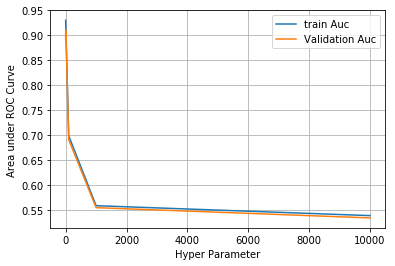

In [12]:
plt.plot(alphaValues,aucTrain, label='train Auc')
plt.plot(alphaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [62]:
print(aucCv)
# print(aucTrain)

[0.8911440693353768, 0.895818064371412, 0.900739661911514, 0.9056796387168815, 0.909931438791628, 0.8981634910007407, 0.691101811813182, 0.555357512517283, 0.5348412985301594]


### Observation
for alpha = 1  we got the maximumvalidation AUC

In [46]:
mnbBow = MultinomialNB(alpha = 1)
mnbBow.fit(xTrain, y_tr)

pred_prob = mnbBow.predict_proba(xTrain)
pred_prob1 = mnbBow.predict_proba(xTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(y_test, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbBow.predict(xTest)

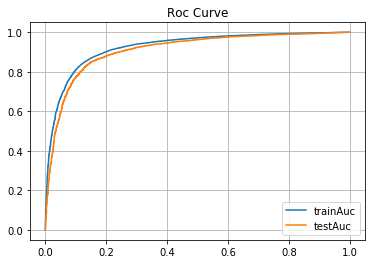

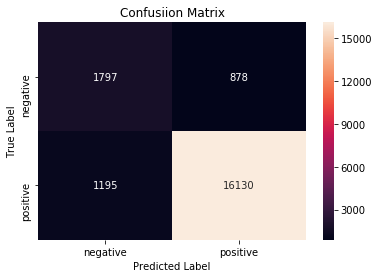

In [47]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



### Observation 
we got an AUC curve with straight line and for some reason TNR in confusion matrix is zero it's like the model isbiased toward the +ve reviews

In [49]:
print(auc2)

0.9095047349327724


In [50]:
tableData.add_row(['BOW', "NaiveBayes", 1, auc2])

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [51]:
# to get features names from the BOW
bowFeatures = count_vect.get_feature_names()
len(bowFeatures)

5000

In [52]:
# Please write all the code with proper documentation
#to count all the features
bowFeatureCount = mnbBow.feature_count_
bowFeatureCount.shape

(2, 5000)

In [53]:

mnbBow.class_count_

array([ 6853., 53147.])

In [54]:
# Empirical log probability of features given a class(i.e. P(x_i|y))
# to get the log probability of features with respet to class
logProb = mnbBow.feature_log_prob_
logProb

array([[-10.83014437, -10.49367213,  -7.46284854, ..., -11.05328792,
        -11.7464351 , -11.7464351 ],
       [-11.42232438,  -9.84334568,  -7.04845593, ..., -10.56790905,
        -11.19918083, -10.7291772 ]])

In [55]:
# storing the features probability with features name as their index
featureTable = pd.DataFrame(logProb, columns = bowFeatures)


In [56]:
featureTable.head()

,abandon,abil,abl,absenc,absolut,absorb,abund,acai,accent,accept,...,zinc,zing,zinger,zip,ziploc,ziplock,zipper,ziti,zucchini,zuke
0,-10.830144,-10.493672,-7.462849,-10.830144,-7.512329,-10.493672,-11.746435,-10.493672,-11.340970,-8.568381,...,-10.647823,-11.053288,-12.439582,-10.493672,-10.830144,-11.34097,-11.340970,-11.053288,-11.746435,-11.746435
1,-11.422324,-9.843346,-7.048456,-11.473618,-7.008315,-9.469297,-10.656857,-9.929420,-10.952321,-9.690669,...,-10.611394,-9.853708,-10.526236,-9.952149,-10.633867,-10.78047,-11.422324,-10.567909,-11.199181,-10.729177


In [57]:
featureTab = featureTable.T
featureTab.head()

,0,1
abandon,-10.830144,-11.422324
abil,-10.493672,-9.843346
abl,-7.462849,-7.048456
absenc,-10.830144,-11.473618
absolut,-7.512329,-7.008315


In [58]:
# To show top 10 feature from +ve class
# Feature Importance
print("\n\n Top 10 Positive Features:-\n",featureTab[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 like      -4.419168
tast      -4.440854
tea       -4.559566
good      -4.590964
flavor    -4.618264
great     -4.622934
love      -4.704943
use       -4.747826
one       -4.782252
product   -4.817500
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [59]:
# Please write all the code with proper documentation
# To show top 10 feature from -ve class

print("Top 10 Negative Features:-\n",featureTab[0].sort_values(ascending = False)[0:10])


Top 10 Negative Features:-
 tast      -4.161154
like      -4.259261
product   -4.357180
one       -4.660534
flavor    -4.771489
would     -4.837181
tri       -4.848730
good      -4.951849
tea       -5.130370
buy       -5.139785
Name: 0, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [74]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
alphaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [75]:
for alpha in alphaValues:
    mnb = MultinomialNB(alpha = alpha)
    mnb.fit(xTrain1, y_tr)
    predTrain = mnb.predict_proba(xTrain1)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = mnb.predict_proba(xCv1)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(alpha, " alpha iteration done")

0.0001  alpha iteration done
0.001  alpha iteration done
0.01  alpha iteration done
0.1  alpha iteration done
1  alpha iteration done
10  alpha iteration done
100  alpha iteration done
1000  alpha iteration done
10000  alpha iteration done


In [76]:
print(aucCv)

[0.9267801971486745, 0.9281704089984377, 0.9296491159541719, 0.93142089825131, 0.9319089205580764, 0.8931968220095545, 0.7287753234322893, 0.6620609777122677, 0.6498548006355678]


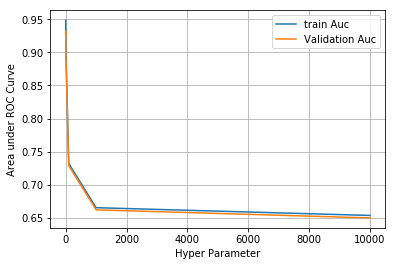

In [77]:
plt.plot(alphaValues,aucTrain, label='train Auc')
plt.plot(alphaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


### Observation
At alpha = 0.1 we get maximum auc for the cross validate data set

In [83]:
mnbTf = MultinomialNB(alpha = 1)
mnbTf.fit(xTrain1, y_tr)

pred_prob = mnbTf.predict_proba(xTrain1)
pred_prob1 = mnbTf.predict_proba(xTest1)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, pred_prob[:,1])
auc1 = metrics.auc(fpr1, tpr1)
auc1
fpr2, tpr2, thresholds = metrics.roc_curve(y_test, pred_prob1[:,1])
auc2 = metrics.auc(fpr2, tpr2)
auc2

y_pred = mnbTf.predict(xTest1)

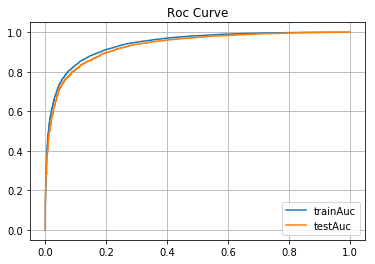

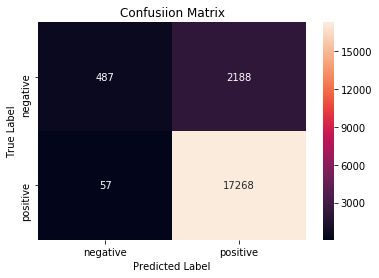

In [84]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



### Observation
we get a straight line in the roc curve and in confusion matrix TNR is nill so model is biased toward the positive reviews

In [85]:
# Please write all the code with proper documentation
print(auc2)

0.9319037639411472


In [81]:
tableData.add_row(['TF-IDF', "NaiveBayes", 1, auc2])

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [87]:
# to get features names from the BOW
tfFeatures = tf_idf_vect.get_feature_names()
len(tfFeatures)

5000

In [88]:
# Please write all the code with proper documentation
#to count all the features
tfFeatureCount = mnbTf.feature_count_
tfFeatureCount.shape

(2, 5000)

In [89]:

mnbTf.class_count_

array([ 6853., 53147.])

In [91]:
# Empirical log probability of features given a class(i.e. P(x_i|y))
# to get the log probability of features with respet to class
logProb = mnbTf.feature_log_prob_
logProb

array([[ -9.83396444,  -7.6820005 , -10.31362557, ...,  -7.96159407,
        -10.02335736, -10.00042295],
       [ -9.61437773,  -7.12127261,  -9.10824536, ...,  -9.23407707,
         -9.52916462,  -9.57280834]])

In [92]:
# storing the features probability with features name as their index
featureTable = pd.DataFrame(logProb, columns = tfFeatures)


In [93]:
featureTable.head()

,abil,abl,abl buy,abl eat,abl find,abl get,abl order,abl purchas,absolut,absolut best,...,yuban,yuck,yucki,yum,yum yum,yummi,zen,zero,zing,zip
0,-9.833964,-7.682001,-10.313626,-9.418233,-9.646615,-9.387531,-9.808838,-10.348188,-7.674392,-10.334077,...,-10.033297,-7.665977,-8.958109,-9.863065,-10.555887,-8.632035,-10.555887,-7.961594,-10.023357,-10.000423
1,-9.614378,-7.121273,-9.108245,-9.903663,-8.373954,-8.992559,-9.312466,-9.501415,-7.038611,-8.897706,...,-9.825775,-10.417691,-10.153023,-7.880007,-9.627943,-7.190791,-10.341362,-9.234077,-9.529165,-9.572808


In [94]:
featureTab = featureTable.T
featureTab.head()

,0,1
abil,-9.833964,-9.614378
abl,-7.682001,-7.121273
abl buy,-10.313626,-9.108245
abl eat,-9.418233,-9.903663
abl find,-9.646615,-8.373954


In [95]:
# To show top 10 feature from +ve class
# Feature Importance
print("\n\n Top 10 Positive Features:-\n",featureTab[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 tea       -5.179143
great     -5.197865
tast      -5.270098
love      -5.272184
good      -5.280939
like      -5.304228
flavor    -5.383433
product   -5.431180
use       -5.485686
one       -5.569078
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [96]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# To show top 10 feature from -ve class

print("Top 10 Negative Features:-\n",featureTab[0].sort_values(ascending = False)[0:10])


Top 10 Negative Features:-
 tast      -5.037841
product   -5.137507
like      -5.157762
would     -5.482224
one       -5.511411
flavor    -5.565078
order     -5.633280
tri       -5.656861
buy       -5.673288
tea       -5.760930
Name: 0, dtype: float64


# [6] Conclusions

In [97]:
# Please compare all your models using Prettytable library
print(tableData)

+------------+------------+-------+--------------------+
| Vectorizer |   Model    | alpha |        AUC         |
+------------+------------+-------+--------------------+
|    BOW     | NaiveBayes |   1   | 0.9095047349327724 |
|   TF-IDF   | NaiveBayes |   1   | 0.9319037639411472 |
+------------+------------+-------+--------------------+


**BOW** alpha is 1
**TF-Idf** alpha is 1
Model Tf-Idf perform better than the Model BOW